In [1]:
%matplotlib inline

In [2]:
import matplotlib
import matplotlib.pyplot as plt
from pylab import *
from math import *
import pandas as pd
import xlrd
from netCDF4 import Dataset
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.animation as animation
import iris
import iris.coord_categorisation
import iris.quickplot as qplt
import cartopy.crs as ccrs

C:\Users\WIN 10\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [20]:
#import data
book=pd.read_excel('data/AWS.xlsx')
pasar=pd.read_excel('data/data pasar.xlsx')
pinggir=pd.read_excel('data/data pinggir.xlsx')
pinggir.head()

,Jam,kadar (ppm),keadaan
0,12:00:00,2,lancar
1,12:05:00,1,lancar
2,12:10:00,0,agak merayap
3,12:15:00,0,aga ramai
4,12:20:00,0,aga ramai


In [21]:
book['kadar pasar'] = pasar['kadar']
book['kadar pinggir'] = pinggir['kadar (ppm)']
book.head()

,No,Jam,Temp,Kec,Arah,Hum,Tek,kadar pasar,kadar pinggir
0,1,12:00:00,32,0.4,292.5,44,927.9,2,2
1,2,12:05:00,33,0.9,135.0,40,927.9,0,1
2,3,12:10:00,32,1.8,202.5,41,927.7,0,0
3,4,12:15:00,33,0.4,202.5,41,927.7,2,0
4,5,12:20:00,33,0.0,225.0,39,927.6,8,0


In [29]:
arah = book['Arah']
kec = book['Kec']
jam = np.linspace(0, 90, num=19, endpoint=True)

### INTERPOLASI

In [35]:
u = [0 for x in range(0,19)]
v = [0 for x in range(0,19)]

In [36]:
for i in range (0,19):
    u[i]=kec[i]*cos(arah[i])
    v[i]=kec[i]*sin(arah[i])

In [37]:
u1=np.array(u)
v1=np.array(v)

<function matplotlib.pyplot.show(*args, **kw)>

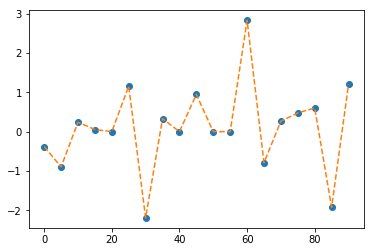

In [38]:
jam1 = np.linspace(0, 90, num=1081, endpoint=True)
f = interp1d(jam, u1)
f2 = interp1d(jam, v1)
ui=f(jam1)
vi=f2(jam1)

plt.plot(jam,u1,'o',jam1,ui,'--')
plt.show

### EULARIAN

In [39]:
Lx = 120;  dx = 10;  x = np.arange(0,Lx+1,dx); # m
Ly = 200;  dy = 10;  y = np.arange(0,Ly+1,dy); # m
Lt = 3600;  dt = 5;  t = np.arange(0,Lt+1,dt); # s

nx = np.size(x); ny = np.size(y); nt = np.size(t)

u = np.zeros((nx,ny,nt))    # m/s
v = np.zeros((nx,ny,nt))   # m/s
# c = np.zeros((nx,ny,nt))    # gr/m3

In [40]:
c0 = np.zeros((nx,ny,nt))
c05 = np.zeros((nx,ny,nt))
c1 = np.zeros((nx,ny,nt))
c15 = np.zeros((nx,ny,nt))
c2 = np.zeros((nx,ny,nt))

In [76]:
q = np.mean(book.loc[0:15,'kadar pasar']) #utara
w = np.mean(book.loc[0:15,'kadar pinggir']) #timur
e = (10*1.126902/100) #barat dan selatan
q

8.25

In [43]:
for i in range (0,nt):
    u[:,:,i]=ui[i]
    v[:,:,i]=vi[i]

In [44]:
kk=0
for kkk in range (0,5):
    c = np.zeros((nx,ny,nt)) 
    c[0:nx,20,0] = q
    c[12,0:ny-1,0] = w
    c[0:nx-1,0,0] = e
    c[0,0:ny-1,0] = e
    
    for it in range(1,nt):  # prediksi 
        uu = u[:,:,it-1]  # for brevity, params at it-1
        vv = v[:,:,it-1]
        cc = c[:,:,it-1]
        for ix in range(1,nx-1):
            c[ix,20,it] = q
            c[ix,0,it] = e
            for iy in range(1,ny-1):
                c[12,iy,it] = w
                c[0,iy,it] = e

                # 1. Total advection
                #    -- basic advection term
                if (uu[ix,iy]>=0):
                    uadv = uu[ix,iy]*(cc[ix,iy]-cc[ix-1,iy])/(dx)
                else:
                    uadv = uu[ix,iy]*(cc[ix+1,iy]-cc[ix,iy])/(dx)
                if (vv[ix,iy]>=0):
                    vadv = vv[ix,iy]*(cc[ix,iy]-cc[ix,iy-1])/(dy)
                else:
                    vadv = vv[ix,iy]*(cc[ix,iy+1]-cc[ix,iy])/(dy)
                adv = uadv + vadv
                #    -- divergence term
                dudx = (uu[ix+1,iy] - uu[ix-1,iy])/(2*dx)
                dvdy = (vv[ix,iy+1] - vv[ix,iy-1])/(2*dy)
                div = cc[ix,iy]*dudx + cc[ix,iy]*dvdy
                #    -- hence
                TotAdv = - adv - div
                # 2. Source term
                #Src = -0.02*cc[ix,iy];
                Src = 0
                # 3. Molecular diffusion
                MolDif = 0
                # 4. Turbulent diffusion
                Kx = kk; Ky = Kx;
                difx = Kx * (cc[ix+1,iy]+cc[ix-1,iy]-2*cc[ix,iy])/(dx**2)
                dify = Ky * (cc[ix,iy+1]+cc[ix,iy-1]-2*cc[ix,iy])/(dy**2)
                difz = 0;
                TurDif = difx + dify + difz
                c[ix,iy,it] = cc[ix,iy] + dt*(TotAdv + Src + MolDif + TurDif)
    if (kk==0):
        c0=c
    if (kk==0.5):
        c05=c
    if (kk==1.0):
        c1=c
    if (kk==1.5):
        c15=c
    if (kk==2):
        c2=c
        
    kk=kk+0.5

In [45]:
%matplotlib qt

MovieWriter ffmpeg unavailable. Trying to use pillow instead.


0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
0


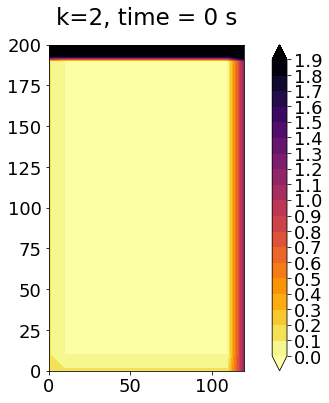

In [47]:
Yh,Xh = np.meshgrid(y,x)
level = np.arange(0,2,0.1)

fig = plt.figure(figsize=(10,6))
ax = plt.axes(xlim=(0, Lx), ylim=(0, Ly), aspect='equal')
conc = plt.contourf(Xh,Yh,c2[:,:,0],level, extend='both', cmap='inferno_r')
fig.colorbar(conc, ticks=level)

FONT_SIZE = 18
plt.rc('font', size=FONT_SIZE)
plt.rc('axes', titlesize=FONT_SIZE+5)
plt.rc('xtick', labelsize=FONT_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=FONT_SIZE)    # fontsize of the tick labels

def animate(ifr): # loop according to frame number it
    print(ifr)
    it = ifr*10
    Ch = c2[:,:,it]
    conc = plt.contourf(Xh,Yh,Ch,level, extend='both', cmap='inferno_r')
    ax.set_title('k=2, time = %i s' % t[it] ,pad=20)
    return conc

# Note: to show animated window in IPython, 
#       execute the following command in the console: %matplotlib qt    
ani = animation.FuncAnimation(fig, animate, frames=int(nt/10)+1, interval=200,
                              repeat=False)
ani.save('hasil/k2.gif')

### Time Series

In [52]:
%matplotlib inline

In [53]:
m=find(x==60)
n=find(y==100)

cp2 = c2[m,n,:]
cp0 = c0[m,n,:]
cp05 = c05[m,n,:]
cp1 = c1[m,n,:]
cp15 = c15[m,n,:]

jam2=jam1[0:721]

cp0[cp0 < 0] = nan
cp05[cp05 < 0] = nan
cp1[cp1 < 0] = nan
cp15[cp15 < 0] = nan
cp2[cp2 < 0] = nan

C:\Users\WIN 10\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: MatplotlibDeprecationWarning: The find function was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  """Entry point for launching an IPython kernel.
C:\Users\WIN 10\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: The find function was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  


In [54]:
k = 10
j=0
timex = [0 for x in range(0,19)]
timex[0]='12:00'
timex[1]='12:05'

for i in range (2,19):
    timex[i]='12:'+str(k)
    k=k+5
    if (k==65):
        timex[i]='13:00'
    if (k==70):
        timex[i]='13:05'
    if (k>70):
        k = 10
        timex[i]='13:'+str(k)
        j=10
    if (j==10):
        timex[i]='13:'+str(k)

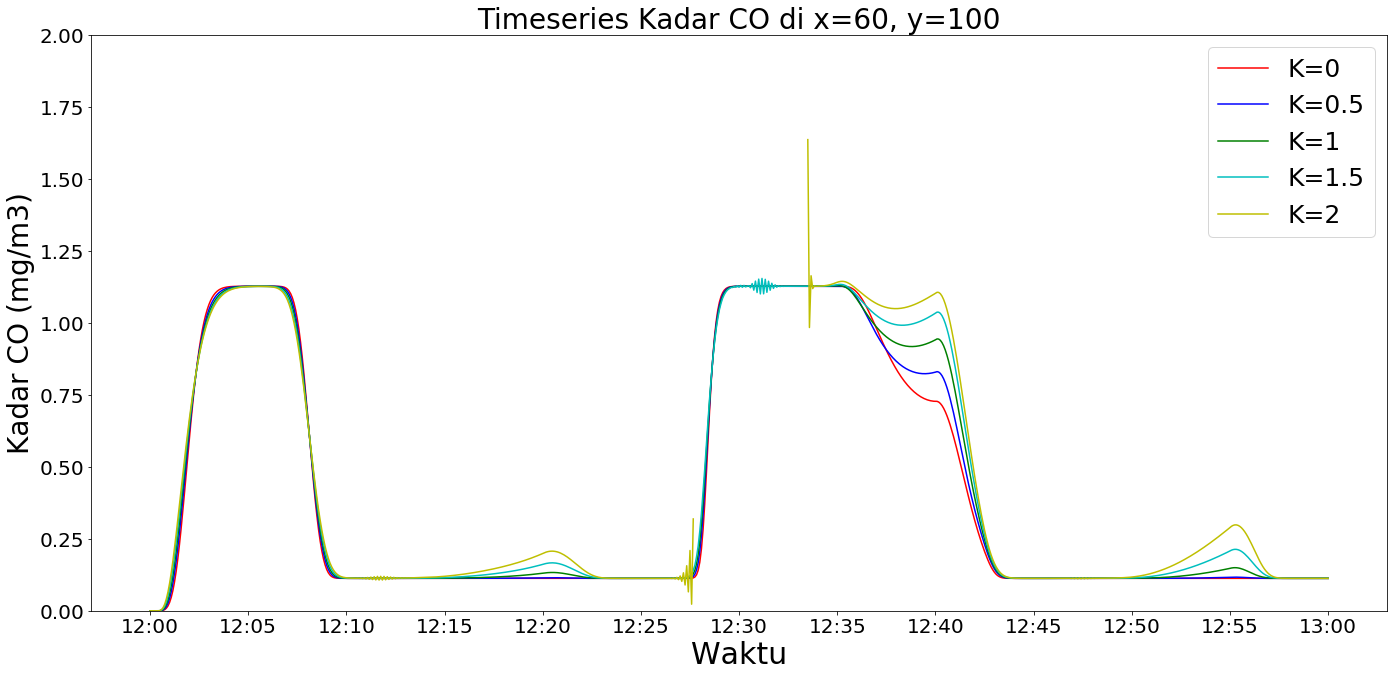

In [58]:
fig2 = plt.figure()
ax1 = fig2.add_axes([0, 0, 3, 2])
ax2 = fig2.add_axes([0, 0, 3, 2])
ax3 = fig2.add_axes([0, 0, 3, 2])
ax4 = fig2.add_axes([0, 0, 3, 2])
ax5 = fig2.add_axes([0, 0, 3, 2])

ax1.plot(jam2, cp0[0,:], 'r')
ax2.plot(jam2, cp05[0,:], 'b')
ax3.plot(jam2, cp1[0,:], 'g')
ax4.plot(jam2, cp15[0,:], 'c')
ax5.plot(jam2, cp2[0,:], 'y')

ax1.set_xlabel('Waktu', fontsize = 30)
ax1.set_ylabel('Kadar CO (mg/m3)', fontsize = 28)
ax1.set_title('Timeseries Kadar CO di x=60, y=100', fontsize = 28)
ax1.tick_params(labelsize = 20)

xticks(np.arange(0,65,5), (timex))

ax1.set_ylim([0,2])
ax1.legend(["K=0", "K=0.5", "K=1","K=1.5", "K=2"],loc=0,fontsize = 25)

fig2.savefig('hasil/Time Series.jpg',bbox_inches='tight')

In [56]:
cpp = [nan for x in range(0,5)]
cpp[0]=cp0[0,:]
cpp[1]=cp05[0,:]
cpp[2]=cp1[0,:]
cpp[3]=cp15[0,:]
cpp[4]=cp2[0,:]

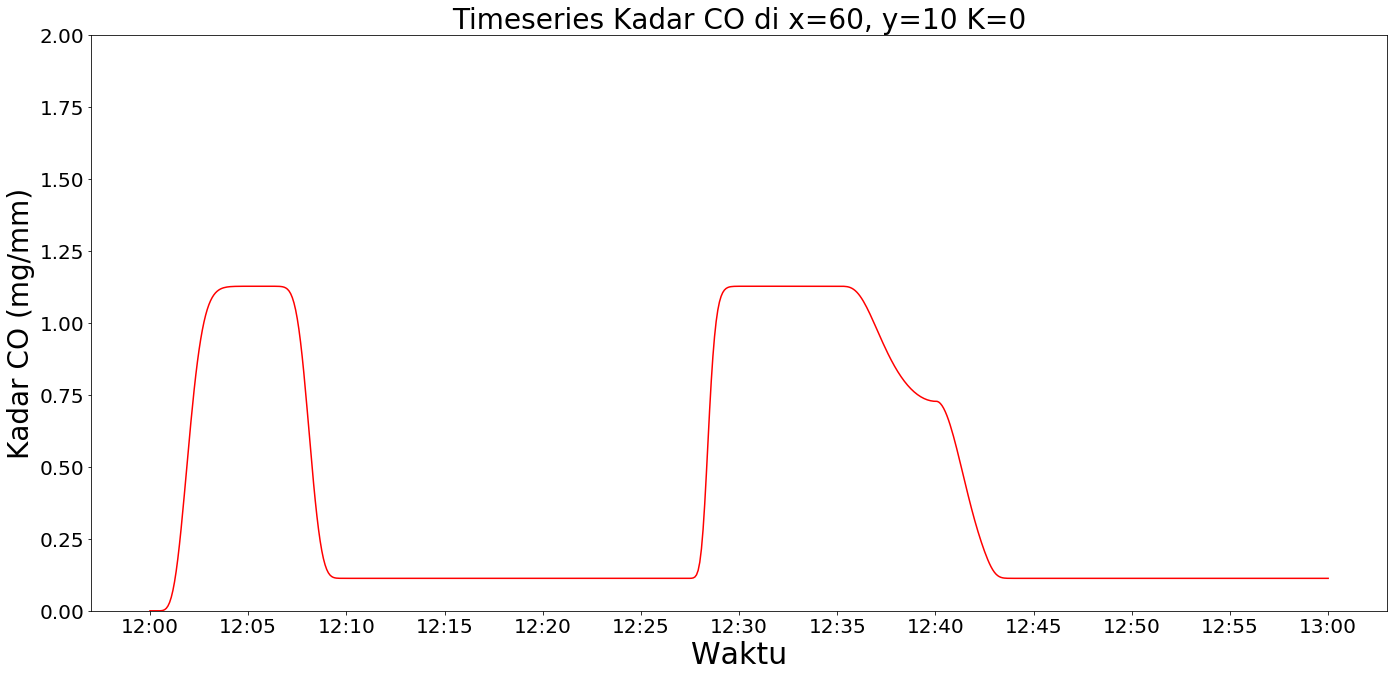

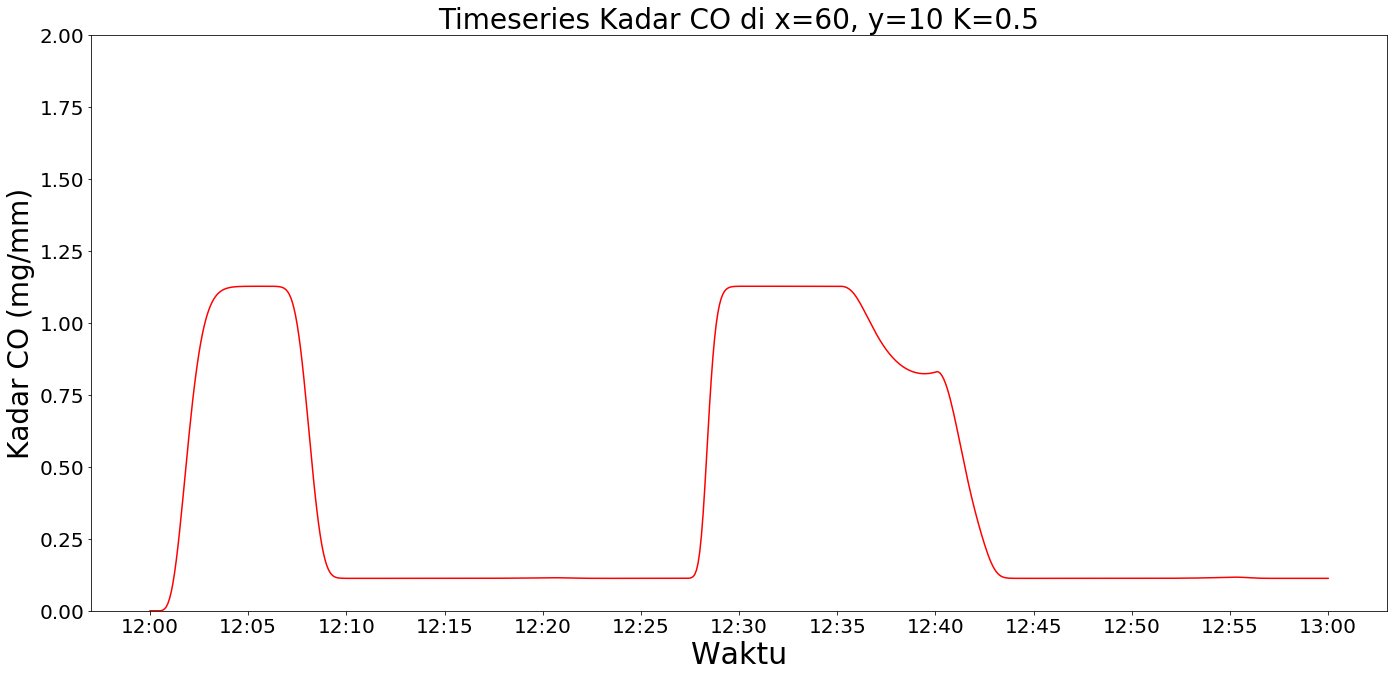

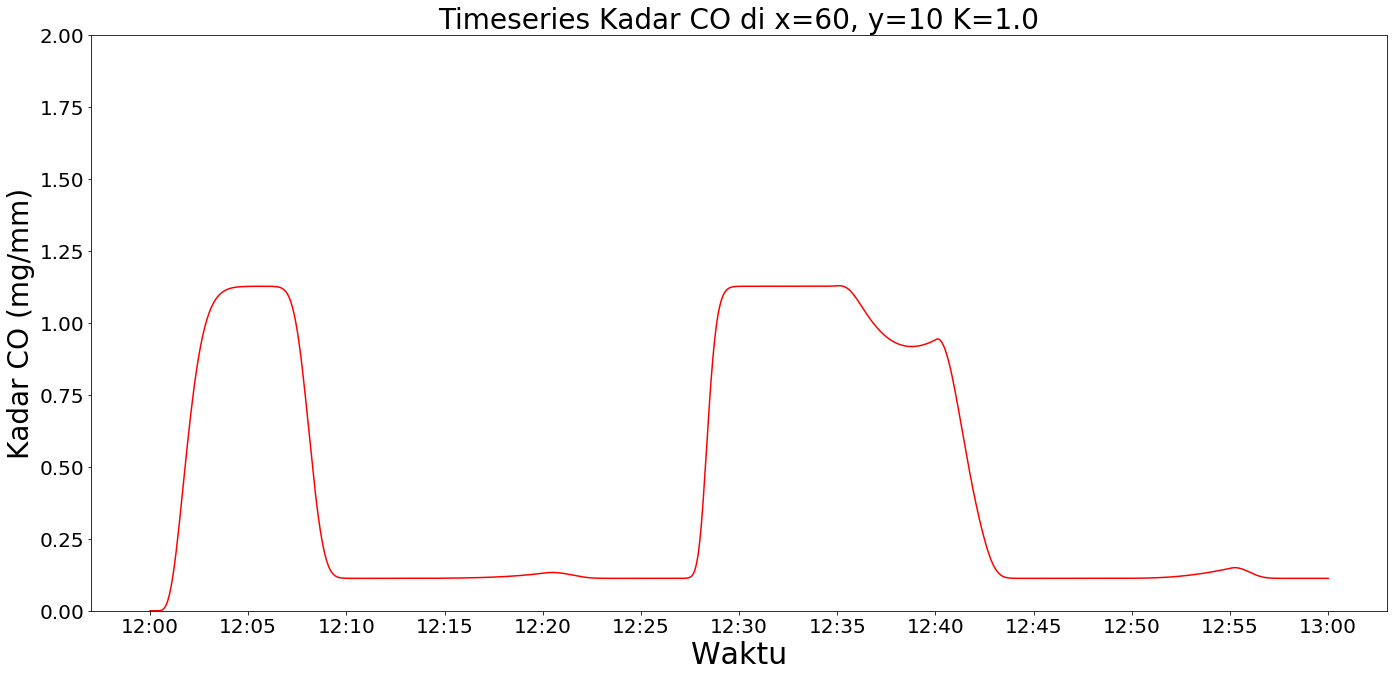

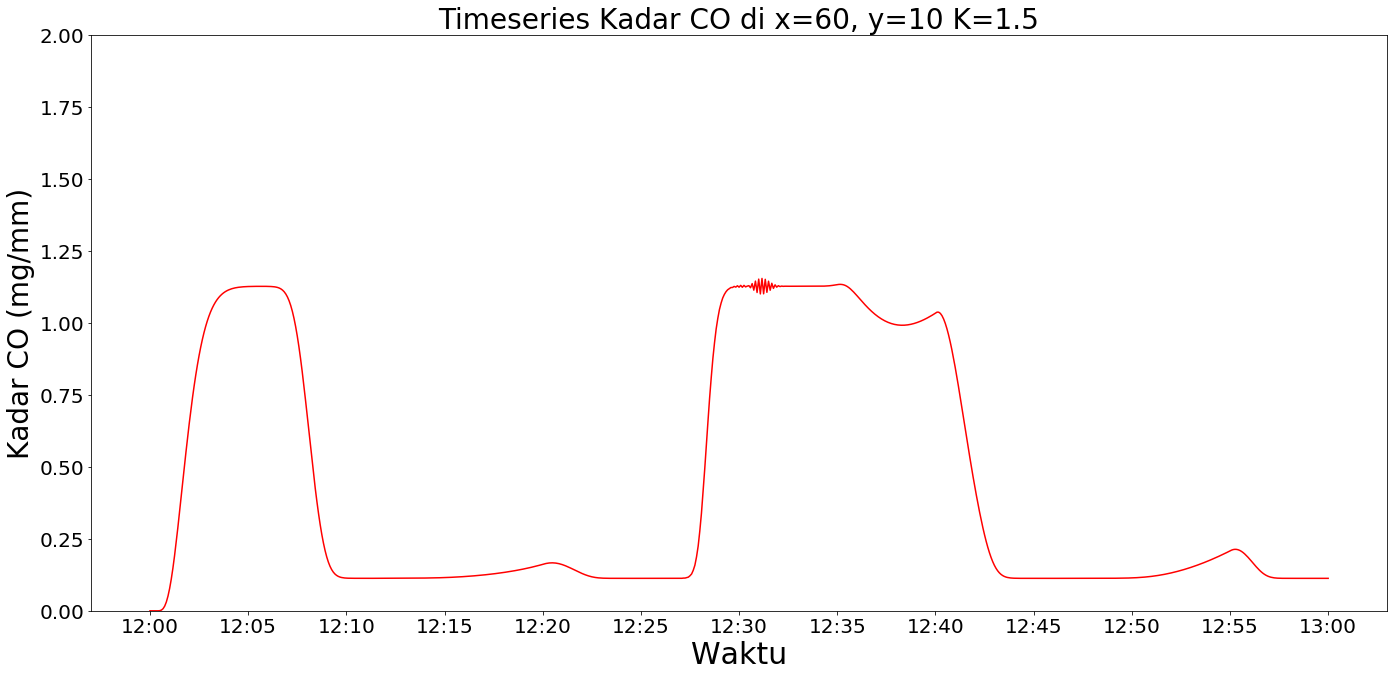

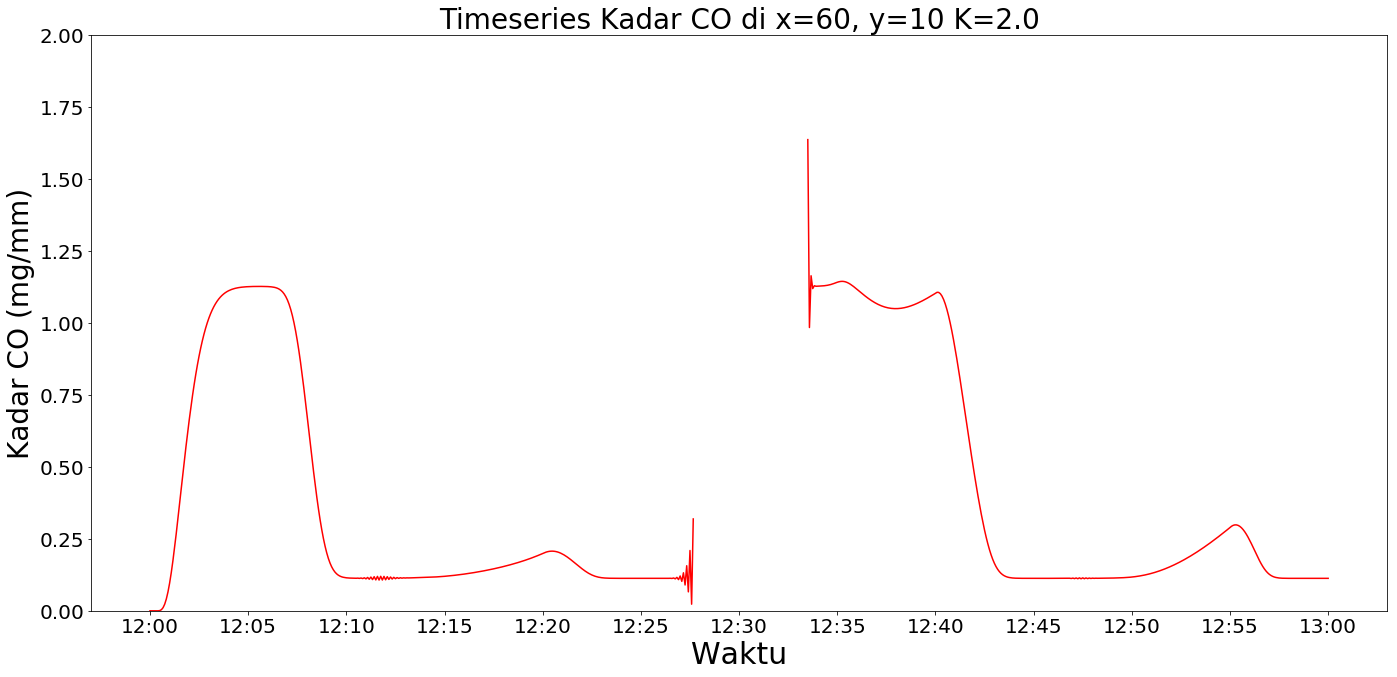

In [59]:
kk=0

for i in range (0,5):
    fig1 = plt.figure()
    ax1 = fig1.add_axes([0, 0, 3, 2])
    ax1.plot(jam2, cpp[i], 'r')
    ax1.set_xlabel('Waktu', fontsize = 30)
    ax1.set_ylabel('Kadar CO (mg/mm)', fontsize = 28)
    ax1.set_title('Timeseries Kadar CO di x=60, y=10 K='+str(kk), fontsize = 28)
    ax1.tick_params(labelsize = 20)
    ax1.set_ylim([0,2])
    
    xticks(np.arange(0,65,5), (timex))
    fig1.savefig('hasil/Time Series k'+str(i)+'.jpg',bbox_inches='tight')
    
    kk=kk+0.5

### Hovmoller

In [60]:
ux=np.transpose(u[m,:,:])*1.944
uy=np.transpose(u[:,n,:])*1.944
vx=np.transpose(v[m,:,:])*1.944
vy=np.transpose(v[:,n,:])*1.944
print(ny)
print(nx)

21
13


In [61]:
ux1 = np.zeros((nt,ny,1))
uy1 = np.zeros((nt,1,nx))
vx1 = np.zeros((nt,ny,1))
vy1 = np.zeros((nt,1,nx))

ux1[ux1 == 0] = nan
uy1[uy1 == 0] = nan
vx1[vx1 == 0] = nan
vy1[vy1 == 0] = nan
    
for i in range (0,721,60):
    ux1[i,0:19,0]=ux[i,0:19,0]
    uy1[i,0,0:12]=uy[i,0,0:12]
    vx1[i,0:19,0]=vx[i,0:19,0]
    vy1[i,0,0:12]=vy[i,0,0:12]

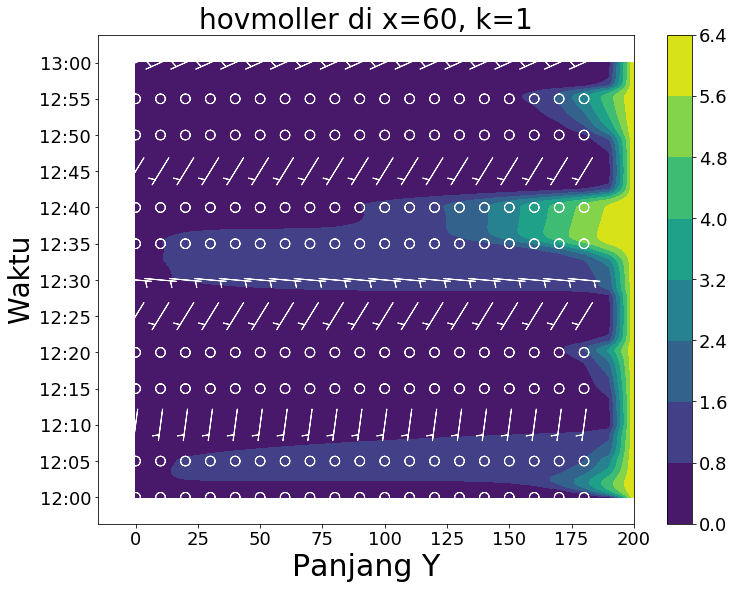

In [63]:
#di x=60 k=1
cx1 = c1[m,:,:]
# levels=np.arange(0,7000,800)
cxx1 = np.transpose(cx1[0,:,:])

fig, (ax1) = plt.subplots(figsize=(12, 9))
im = ax1.contourf(y, jam2, cxx1,  cmap=get_cmap("viridis"))
ax1.barbs(y, jam2,ux1[:,:,0], vx1[:,:,0], length=8, pivot='middle', barbcolor='w')

ax1.set_xlabel('Panjang Y', fontsize = 30)
ax1.set_ylabel('Waktu', fontsize = 28)
fig.colorbar(im)
yticks(np.arange(0,65,5), (timex))
ax1.set_title('hovmoller di x=60, k=1', fontsize = 28)

fig.savefig('hasil/hovmoller x=60 k=1.jpg',bbox_inches='tight')

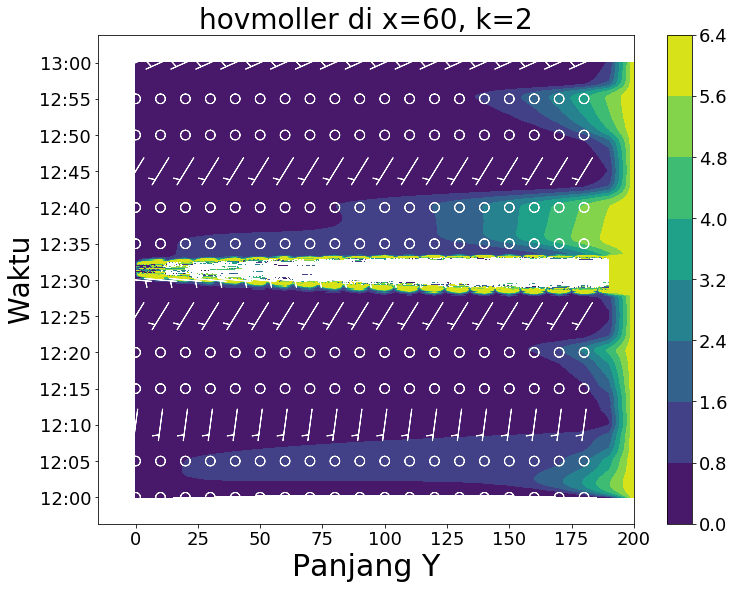

In [65]:
#di x=60 k=2
cx2 = c2[m,:,:]
levels=np.arange(0,6.5,0.8)
cxx2 = np.transpose(cx2[0,:,:])
# cx1.shape

fig, (ax1) = plt.subplots(figsize=(12, 9))
im = ax1.contourf(y, jam2, cxx2, levels=levels, cmap=get_cmap("viridis"))
ax1.barbs(y, jam2,ux1[:,:,0], vx1[:,:,0], length=8, pivot='middle', barbcolor='w')
ax1.set_xlabel('Panjang Y', fontsize = 30)
ax1.set_ylabel('Waktu', fontsize = 28)
fig.colorbar(im)
ax1.set_title('hovmoller di x=60, k=2', fontsize = 28)
yticks(np.arange(0,65,5), (timex))

fig.savefig('hasil/hovmoller x=60 k=2.jpg',bbox_inches='tight')

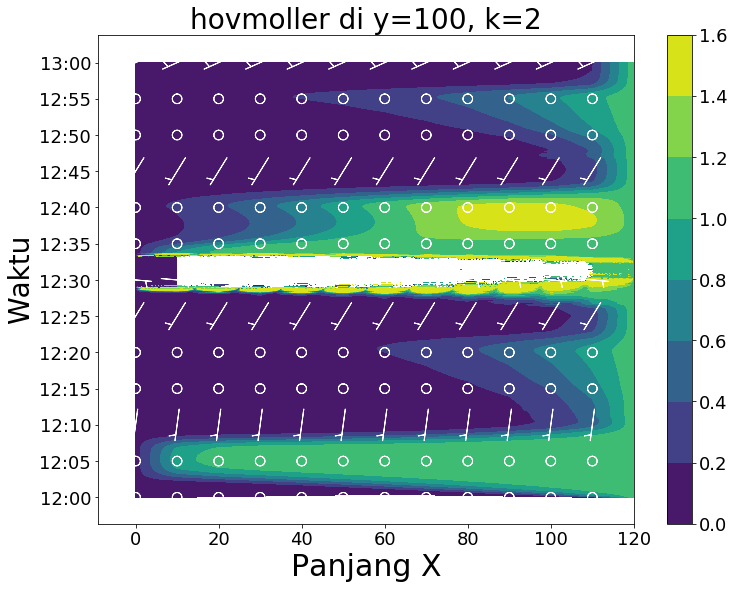

In [66]:
#di y=100 k=2
cx2 = c2[:,n,:]
levels=np.arange(0,1.7,0.2)
cxx2 = np.transpose(cx2[:,0,:])

fig, (ax1) = plt.subplots(figsize=(12, 9))
im = ax1.contourf(x, jam2, cxx2, levels=levels, cmap=get_cmap("viridis"))
ax1.barbs(x, jam2,uy1[:,0,:], vy1[:,0,:], length=8, pivot='middle', barbcolor='w')

ax1.set_xlabel('Panjang X', fontsize = 30)
ax1.set_ylabel('Waktu', fontsize = 28)
fig.colorbar(im)
ax1.set_title('hovmoller di y=100, k=2', fontsize = 28)
yticks(np.arange(0,65,5), (timex))

fig.savefig('hasil/hovmoller y=100 k=2.jpg',bbox_inches='tight')

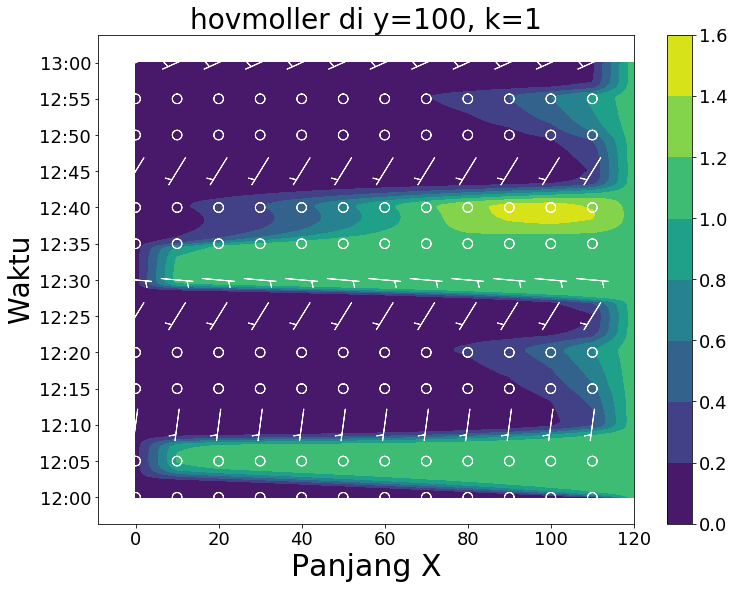

In [67]:
#di y=100 k=1
cx1 = c1[:,n,:]
# levels=np.arange(0,2000,100)
cxx1 = np.transpose(cx1[:,0,:])

fig, (ax1) = plt.subplots(figsize=(12, 9))
# im = ax1.contourf(x, jam2, cxx1,  cmap=get_cmap("CMRmap"))
im = ax1.contourf(x, jam2, cxx1, cmap=get_cmap("viridis"))
ax1.barbs(x, jam2,uy1[:,0,:], vy1[:,0,:], length=8, pivot='middle', barbcolor='w')

ax1.set_xlabel('Panjang X', fontsize = 30)
ax1.set_ylabel('Waktu', fontsize = 28)
fig.colorbar(im)
ax1.set_title('hovmoller di y=100, k=1', fontsize = 28)
yticks(np.arange(0,65,5), (timex))

fig.savefig('hasil/hovmoller y=100 k=1.jpg',bbox_inches='tight')